## Gas price USA

#### Load data

In [1]:
import pandas as pd
import numpy as np

In [2]:
weekly_gas_prices = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-07-01/weekly_gas_prices.csv')


In [3]:
weekly_gas_prices.head()

,date,fuel,grade,formulation,price
0,1990-08-20,gasoline,regular,all,1.191
1,1990-08-20,gasoline,regular,conventional,1.191
2,1990-08-27,gasoline,regular,all,1.245
3,1990-08-27,gasoline,regular,conventional,1.245
4,1990-09-03,gasoline,regular,all,1.242


In [4]:
gas = weekly_gas_prices

In [5]:
gas.info()

<class 'pandas.DataFrame'>
RangeIndex: 22360 entries, 0 to 22359
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         22360 non-null  str    
 1   fuel         22360 non-null  str    
 2   grade        22360 non-null  str    
 3   formulation  19672 non-null  str    
 4   price        22360 non-null  float64
dtypes: float64(1), str(4)
memory usage: 873.6 KB


#### Exploring categorical columns

In [6]:
columnas = ['fuel','grade','formulation']

for col in columnas:
    print(gas[col].unique())

<StringArray>
['gasoline', 'diesel']
Length: 2, dtype: str
<StringArray>
['regular', 'all', 'midgrade', 'premium', 'ultra_low_sulfur', 'low_sulfur']
Length: 6, dtype: str
<StringArray>
['all', 'conventional', nan, 'reformulated']
Length: 4, dtype: str


#### Cast columns

In [7]:
gas['date'] = pd.to_datetime(gas['date'], format= '%Y-%m-%d')

In [8]:
gas['date'].dtypes

dtype('<M8[us]')

#### Dividir los DF

In [9]:
fuel = gas['fuel'].unique()

datasets_fuel = {}

for fu  in fuel:
    datasets_fuel[f'{fu}'] = gas[gas['fuel']==fu]
    print(f'Generado el datasets {fu}')

for df in datasets_fuel.values():
    print(df['date'].count())

Generado el datasets gasoline
Generado el datasets diesel
19672
2688


In [10]:
datasets_fuel['diesel'] = datasets_fuel['diesel'][datasets_fuel['diesel']['grade']!= 'all']

In [11]:
for df in datasets_fuel.values():
    print(df.shape)

(19672, 5)
(1056, 5)


### Primer Analisis Diesel

In [12]:
diesel = datasets_fuel['diesel']

In [13]:
diesel.columns

Index(['date', 'fuel', 'grade', 'formulation', 'price'], dtype='str')

In [14]:
# Verificar si es consistente que el disel ultra low sea mas caro el low
print(diesel.groupby(by='grade')['price'].mean().reset_index())
print('--------------------------------')
print(diesel.groupby(by='grade')['price'].median().reset_index())

              grade     price
0        low_sulfur  3.353844
1  ultra_low_sulfur  3.367955
--------------------------------
              grade   price
0        low_sulfur  3.2050
1  ultra_low_sulfur  3.2815


In [15]:
print(diesel.groupby(by='grade').agg({'price':['mean', 'median']}).reset_index())

              grade     price        
                         mean  median
0        low_sulfur  3.353844  3.2050
1  ultra_low_sulfur  3.367955  3.2815


Ultra low sulfur es consistentemente más caro que low sulfur

In [16]:
diesel.loc[:,'año'] = diesel['date'].dt.year

In [17]:
diesel.groupby(by=['año','grade']).agg({'price':['mean','median']}).reset_index()

año             grade     price        
                                mean  median
0   2007        low_sulfur  2.871813  2.8235
1   2007  ultra_low_sulfur  2.941625  2.8755
2   2008        low_sulfur  3.835875  3.9280
3   2008  ultra_low_sulfur  3.813654  3.9725
4   2009  ultra_low_sulfur  2.472654  2.5500
5   2010  ultra_low_sulfur  2.993308  2.9585
6   2011  ultra_low_sulfur  3.839712  3.8900
7   2012  ultra_low_sulfur  3.967736  3.9910
8   2013  ultra_low_sulfur  3.921731  3.8965
9   2014  ultra_low_sulfur  3.824635  3.8840
10  2015  ultra_low_sulfur  2.706635  2.7830
11  2016  ultra_low_sulfur  2.303942  2.3805
12  2017  ultra_low_sulfur  2.650038  2.5825
13  2018  ultra_low_sulfur  3.177642  3.2170
14  2019  ultra_low_sulfur  3.055827  3.0530
15  2020  ultra_low_sulfur  2.550808  2.4370
16  2021  ultra_low_sulfur  3.286750  3.3120
17  2022  ultra_low_sulfur  4.988942  5.1360
18  2023  ultra_low_sulfur  4.214115  4.2240
19  2024  ultra_low_sulfur  3.759623  3.7680
20  2025  ultra_low_sulfur  3.587640  3.5790

Durante los años en los que coexistieron ambos tipos de diésel (2007–2008), el ultra low sulfur fue generalmente más caro. En 2008 se observan episodios puntuales donde el low sulfur presenta picos de precio que afectan la media, pero no la mediana, lo que sugiere eventos transitorios. la entrada en vigor de nuevas regulaciones hace que la low sulfur no exista por ello no hay datos de esta posteriormente del 2008.

#### Pipeline reusable

In [18]:
def prepare_dates(df):
    if 'date' not in df.columns:
        raise ValueError(f'la columna date no esta en el dataframe')

    df_copy = df.copy()
    df_copy['date']= pd.to_datetime(df_copy['date'], format='%Y-%m-%d', errors='coerce')
    df_copy = df_copy[df_copy['date'].notna()]

    return df_copy


def split_by_fuel(df):
    if 'fuel' not in df.columns:
        raise ValueError(f'No esta fuel entre las columnas del dataframe')
    
    fuel = df['fuel'].unique()
    datasets_fuel = {}

    for fu in fuel:
        datasets_fuel[fu]=df[df['fuel'] == fu].copy()

    #for data in datasets_fuel.keys():
        #print(f'El dataset {data} fue creado')   
    
    return datasets_fuel


def clean_diesel(df_diesel):
    if 'grade' not in df_diesel.columns:
        raise ValueError("La columna 'grade' no existe en el DataFrame de diésel")

    df_copy = df_diesel.copy()

    df_copy = df_copy[df_copy['grade'] != 'all']

    return df_copy


def clean_gasoline(df_gasoline, kepp_all:bool=True):
    if 'grade' not in df_gasoline.columns:
        raise ValueError('No se Encuentra la columnas "grade".')
    
    df_copy = df_gasoline.copy()

    if not kepp_all:
        df_copy = df_copy[df_copy['grade'] != 'all']

    return df_copy



def orquestador(df):
    if df.empty:
        raise ValueError('El daatframe vino vacio')
    
    df_copy = df.copy()

    df_date_prep = prepare_dates(df_copy)

    datasets_fuel = split_by_fuel(df_date_prep)

    
    df_diesel = datasets_fuel['diesel']
    df_gasoline = datasets_fuel['gasoline']  

    datasets_fuel_clean = {'diesel':clean_diesel(df_diesel), 'gasoline':clean_gasoline(df_gasoline)}

    return datasets_fuel_clean


#### Prueba de Pipeline diesel

In [19]:
df_gas = weekly_gas_prices.copy()

In [20]:
df_gas.info()

<class 'pandas.DataFrame'>
RangeIndex: 22360 entries, 0 to 22359
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         22360 non-null  datetime64[us]
 1   fuel         22360 non-null  str           
 2   grade        22360 non-null  str           
 3   formulation  19672 non-null  str           
 4   price        22360 non-null  float64       
dtypes: datetime64[us](1), float64(1), str(3)
memory usage: 873.6 KB


In [21]:
datasets_fuel_clean = orquestador(df_gas)

### Analisis Gasolina

##### ¿Cómo ha evolucionado el precio de la gasolina regular desde 1990 hasta hoy?

In [22]:
gasoline = datasets_fuel_clean['gasoline'].copy()
gasoline.head()

,date,fuel,grade,formulation,price
0,1990-08-20,gasoline,regular,all,1.191
1,1990-08-20,gasoline,regular,conventional,1.191
2,1990-08-27,gasoline,regular,all,1.245
3,1990-08-27,gasoline,regular,conventional,1.245
4,1990-09-03,gasoline,regular,all,1.242


In [23]:
gasoline.sort_values(by='date', inplace=True, ascending=True)


In [24]:
gasoline_regular = gasoline[gasoline.loc[:,'grade']=='regular'].copy()
gasoline_regular.head()

,date,fuel,grade,formulation,price
0,1990-08-20,gasoline,regular,all,1.191
1,1990-08-20,gasoline,regular,conventional,1.191
2,1990-08-27,gasoline,regular,all,1.245
3,1990-08-27,gasoline,regular,conventional,1.245
4,1990-09-03,gasoline,regular,all,1.242


In [25]:
gasoline_regular['año'] = gasoline_regular.loc[:,'date'].dt.year

In [26]:
gasoline_regular

,date,fuel,grade,formulation,price,año
0,1990-08-20,gasoline,regular,all,1.191,1990
1,1990-08-20,gasoline,regular,conventional,1.191,1990
2,1990-08-27,gasoline,regular,all,1.245,1990
3,1990-08-27,gasoline,regular,conventional,1.245,1990
4,1990-09-03,gasoline,regular,all,1.242,1990
...,...,...,...,...,...,...
22335,2025-06-16,gasoline,regular,all,3.139,2025
22337,2025-06-16,gasoline,regular,reformulated,3.384,2025
22351,2025-06-23,gasoline,regular,reformulated,3.449,2025
22349,2025-06-23,gasoline,regular,all,3.213,2025


In [27]:
resumen_gasolina = gasoline_regular.groupby(by='año').agg({'price':['mean','median']}).reset_index()
resumen_gasolina.columns = [
    'año', 'mean_price', 'median_price'
]

In [28]:
resumen_gasolina.head()

,año,mean_price,median_price
0,1990,1.298875,1.3220
1,1991,1.098120,1.0985
2,1992,1.086500,1.1125
3,1993,1.067308,1.0645
4,1994,1.077385,1.0790


In [29]:
resumen_gasolina[(resumen_gasolina['año'] >= 2002) & (resumen_gasolina['año'] <= 2021)]

,año,mean_price,median_price
12,2002,1.355199,1.3875
13,2003,1.577205,1.5655
14,2004,1.867064,1.8835
15,2005,2.281756,2.2165
16,2006,2.586615,2.4975
17,2007,2.806893,2.8490
18,2008,3.257423,3.3720
19,2009,2.366821,2.5150
20,2010,2.795962,2.7900
21,2011,3.537577,3.5690


In [30]:
resumen_gasolina['aumento_pct']=resumen_gasolina['median_price'].pct_change() * 100
# Forma a mano
#  precios = resumen_gasolina['median_price']

# for i in range(len(precios) - 1):
#     aumento = ((precios.iloc[i+1] - precios.iloc[i]) / precios.iloc[i]) * 100
#     print(aumento)

In [31]:
resumen_gasolina.head()

,año,mean_price,median_price,aumento_pct
0,1990,1.298875,1.3220,NaN
1,1991,1.098120,1.0985,-16.906203
2,1992,1.086500,1.1125,1.274465
3,1993,1.067308,1.0645,-4.314607
4,1994,1.077385,1.0790,1.362142


El precio de la gasolina regular muestra una tendencia alcista de largo plazo. La mediana permite observar una trayectoria más estable que la media, especialmente en años de crisis (2008, 2020), donde la media se ve afectada por episodios extremos. Tras el shock de 2008, los precios se estabilizan en un rango inferior hasta el periodo post-COVID, donde se observa un nuevo quiebre estructural.

##### ¿Qué tan grande es la diferencia de precio entre regular, midgrade y premium?

In [32]:
gasoline

,date,fuel,grade,formulation,price
0,1990-08-20,gasoline,regular,all,1.191
1,1990-08-20,gasoline,regular,conventional,1.191
2,1990-08-27,gasoline,regular,all,1.245
3,1990-08-27,gasoline,regular,conventional,1.245
4,1990-09-03,gasoline,regular,all,1.242
...,...,...,...,...,...
22347,2025-06-23,gasoline,all,conventional,3.196
22346,2025-06-23,gasoline,all,all,3.338
22356,2025-06-23,gasoline,premium,conventional,3.950
22350,2025-06-23,gasoline,regular,conventional,3.102


In [33]:
gasoline_NoAll = gasoline.loc[gasoline['grade']!='all'].copy()
gasoline_NoAll['año'] = gasoline_NoAll['date'].dt.year

In [34]:
resumen_gasolina_NoAll = gasoline_NoAll.groupby(by=['año','grade'])['price'].median().reset_index()

In [35]:
resumen_gasolina_grade = resumen_gasolina_NoAll.pivot(index='año', columns = 'grade', values = 'price').reset_index()
resumen_gasolina_grade.head()


grade,año,midgrade,premium,regular
0,1990,NaN,NaN,1.3220
1,1991,NaN,NaN,1.0985
2,1992,NaN,NaN,1.1125
3,1993,NaN,NaN,1.0645
4,1994,1.188,1.288,1.0790


In [36]:
resumen_gasolina_grade['premium_diff'] = resumen_gasolina_grade['premium'] - resumen_gasolina_grade['regular']
resumen_gasolina_grade['midgrade_diff'] = resumen_gasolina_grade['midgrade'] - resumen_gasolina_grade['regular']
resumen_gasolina_grade.head()

grade,año,midgrade,premium,regular,premium_diff,midgrade_diff
0,1990,NaN,NaN,1.3220,NaN,NaN
1,1991,NaN,NaN,1.0985,NaN,NaN
2,1992,NaN,NaN,1.1125,NaN,NaN
3,1993,NaN,NaN,1.0645,NaN,NaN
4,1994,1.188,1.288,1.0790,0.209,0.109


In [37]:
resumen_gasolina_grade['premium_pct'] = (resumen_gasolina_grade['premium_diff'] / resumen_gasolina_grade['regular']) * 100
resumen_gasolina_grade['midgrade_pct'] = (resumen_gasolina_grade['midgrade_diff'] / resumen_gasolina_grade['regular']) * 100
resumen_gasolina_grade

grade,año,midgrade,premium,regular,premium_diff,midgrade_diff,premium_pct,midgrade_pct
0,1990,NaN,NaN,1.3220,NaN,NaN,NaN,NaN
1,1991,NaN,NaN,1.0985,NaN,NaN,NaN,NaN
2,1992,NaN,NaN,1.1125,NaN,NaN,NaN,NaN
3,1993,NaN,NaN,1.0645,NaN,NaN,NaN,NaN
4,1994,1.1880,1.2880,1.0790,0.2090,0.1090,19.369787,10.101946
5,1995,1.2275,1.3130,1.1220,0.1910,0.1055,17.023173,9.402852
6,1996,1.3140,1.4070,1.2230,0.1840,0.0910,15.044971,7.440720
7,1997,1.3055,1.3955,1.2110,0.1845,0.0945,15.235343,7.803468
8,1998,1.1380,1.2285,1.0430,0.1855,0.0950,17.785235,9.108341
9,1999,1.3015,1.3730,1.1790,0.1940,0.1225,16.454623,10.390161


La diferencia de precio entre gasolina premium y regular se mantuvo relativamente estable durante dos décadas. Sin embargo, a partir de 2015 se observa un quiebre estructural, con brechas que alcanzan niveles históricos (~30%), acentuadas durante eventos de alto impacto como la pandemia. Esto sugiere que factores no puramente energéticos, como regulación y estructura de mercado, juegan un rol creciente en la segmentación de precios.

### Vizualizaciones

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [39]:
resumen_gasolina_regular = resumen_gasolina.copy()
resumen_gasolina_regular.head()

,año,mean_price,median_price,aumento_pct
0,1990,1.298875,1.3220,NaN
1,1991,1.098120,1.0985,-16.906203
2,1992,1.086500,1.1125,1.274465
3,1993,1.067308,1.0645,-4.314607
4,1994,1.077385,1.0790,1.362142


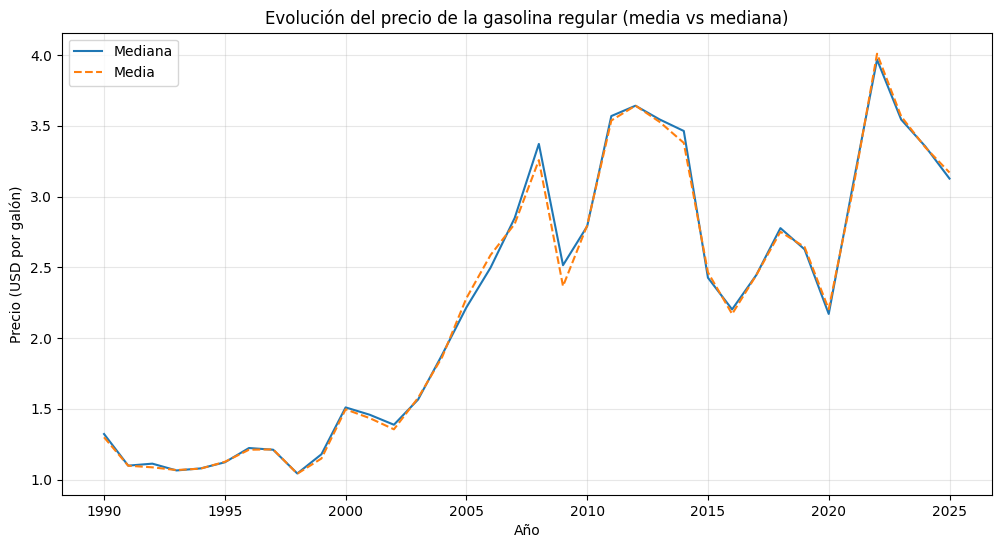

In [40]:
plt.figure(figsize=(12,6))

plt.plot(
    resumen_gasolina_regular['año'],
    resumen_gasolina_regular['median_price'],
    label='Mediana',
)

plt.plot(
    resumen_gasolina_regular['año'],
    resumen_gasolina_regular['mean_price'],
    linestyle='--',
    label='Media',
)

plt.title('Evolución del precio de la gasolina regular (media vs mediana)')
plt.xlabel('Año')
plt.ylabel('Precio (USD por galón)')
plt.legend()
plt.grid(alpha=0.3)

In [41]:
# plt.figure(figsize=(10,6))

# sns.lineplot(resumen_gasolina_regular, x='año', y='median_price', 
#              label = 'Mediana', color='blue')
# sns.lineplot(resumen_gasolina_regular, x='año', 
#              y='mean_price', label = 'Media', 
#              color = 'blue', linestyle ='--')

# plt.legend()
# plt.title('Compracion de la media y la mediana del precio de la gasolina')

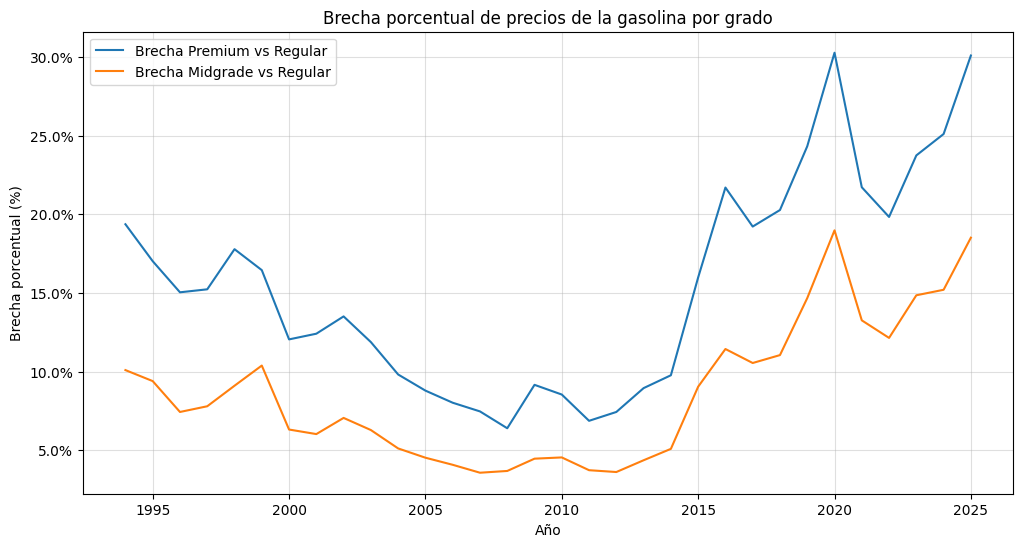

In [42]:
plt.figure(figsize=(12,6))

plt.plot(
    resumen_gasolina_grade['año'],
    resumen_gasolina_grade['premium_pct'],
    label='Brecha Premium vs Regular'
)

plt.plot(
    resumen_gasolina_grade['año'],
    resumen_gasolina_grade['midgrade_pct'],
    label='Brecha Midgrade vs Regular'
)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.title('Brecha porcentual de precios de la gasolina por grado')
plt.xlabel('Año')
plt.ylabel('Brecha porcentual (%)')
plt.grid(alpha=0.4)

plt.show()

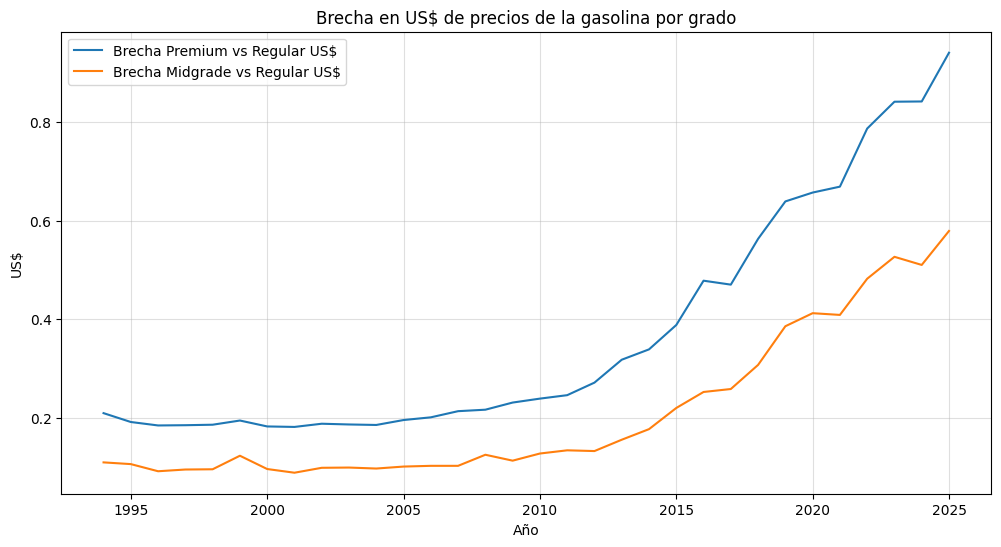

In [43]:
plt.figure(figsize=(12,6))

plt.plot(
    resumen_gasolina_grade['año'],
    resumen_gasolina_grade['premium_diff'],
    label='Brecha Premium vs Regular US$'
)

plt.plot(
    resumen_gasolina_grade['año'],
    resumen_gasolina_grade['midgrade_diff'],
    label='Brecha Midgrade vs Regular US$'
)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.title('Brecha en US$ de precios de la gasolina por grado')
plt.xlabel('Año')
plt.ylabel('US$')
plt.grid(alpha=0.4)

plt.show()

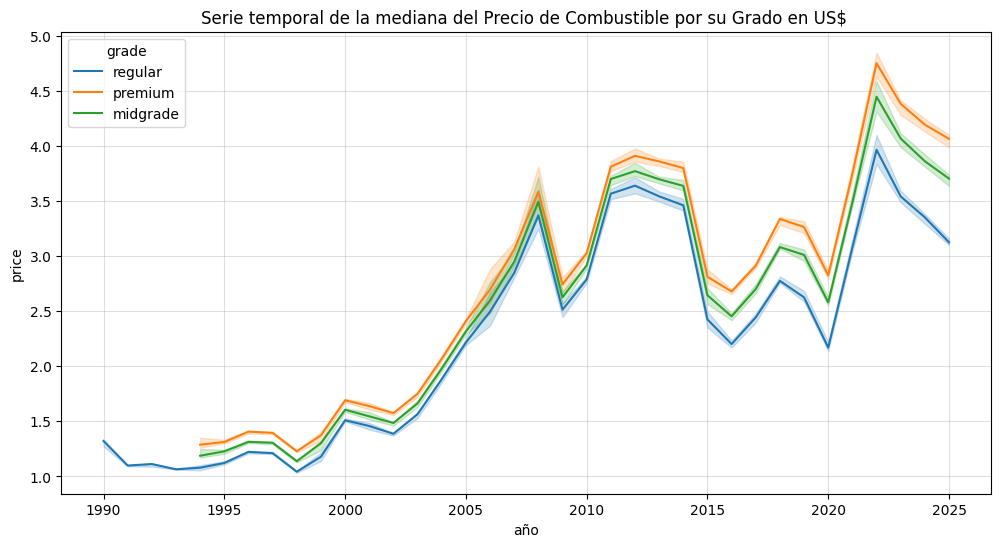

In [55]:
plt.figure(figsize=(12,6))

sns.lineplot(data=gasoline_NoAll, x='año', y='price', hue='grade', estimator= 'median', markers=True)

plt.title('Serie temporal de la mediana del Precio de Combustible por su Grado en US$ ')
plt.grid(alpha=0.4)

Desde mediados de los años 90, la gasolina premium ya presentaba una prima cercana a los 20 centavos por galón respecto a la regular, mientras que la midgrade rondaba los 10 centavos. Con el paso del tiempo, estas brechas se amplían de forma sostenida, alcanzando valores cercanos a 1 USD en periodos recientes. Esto transforma una diferencia inicialmente marginal en una decisión económica relevante para el consumidor.

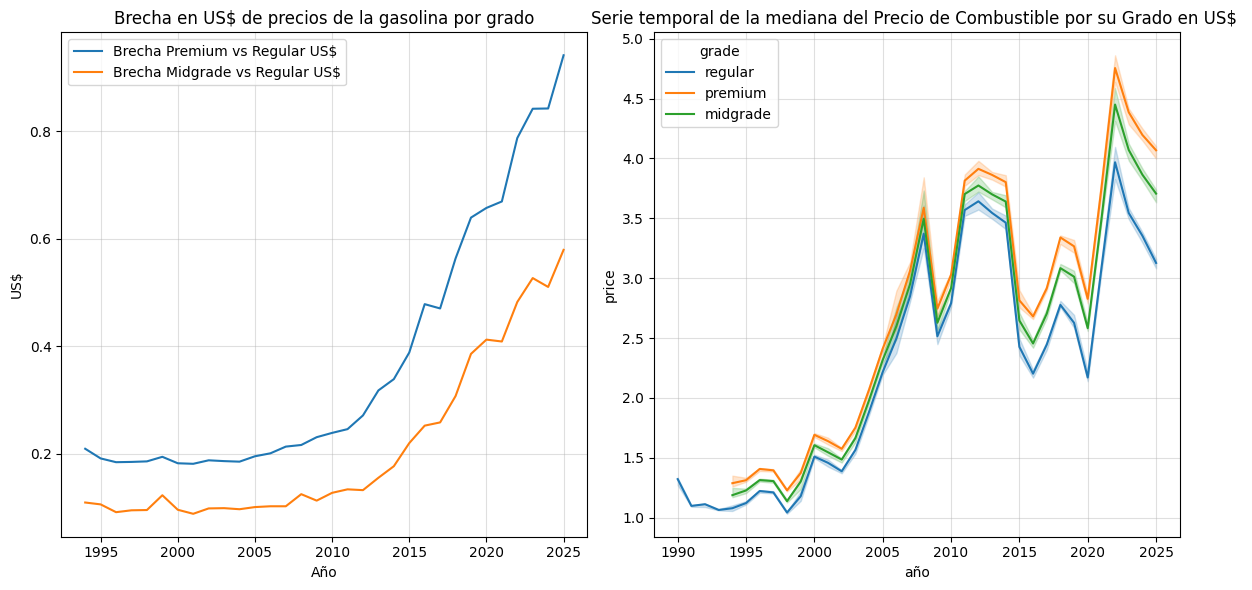

In [ ]:
fig , axes   = plt.subplots(1,2, figsize=(12,6))

axes[0].plot(
    resumen_gasolina_grade['año'],
    resumen_gasolina_grade['premium_diff'],
    label='Brecha Premium vs Regular US$'
)

axes[0].plot(
    resumen_gasolina_grade['año'],
    resumen_gasolina_grade['midgrade_diff'],
    label='Brecha Midgrade vs Regular US$'
)

#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].legend()
axes[0].set_title('Brecha en US$ de precios de la gasolina por grado')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('US$')
axes[0].grid(alpha=0.4)

# ------- Second image--------

sns.lineplot(data=gasoline_NoAll, x='año', y='price', hue='grade', estimator= 'median', markers=True, ax=axes[1])

axes[1].set_title('Serie temporal de la mediana del Precio de Combustible por su Grado en US$ ')
axes[1].grid(alpha=0.4)

plt.tight_layout()
